In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate, integrate, special
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [3]:
df_left = df_left.dropna()
df_left.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [19]:
# df_leftのstart_station_idの型を確認する
df_left['start_station_id'].dtype

dtype('O')

In [4]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        # df_tmpのstart_station_idをstr型に変換してからユニークな値を取得
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [5]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [8]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')
# インデックスを振り直す
left = left.reset_index(drop=True)
left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [9]:
# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# 一番最初の行を削除
left = left.drop(0)

# インデックスを振り直す
left = left.reset_index(drop=True)

In [10]:
left.head()

,node,edge,node_norm,edge_norm
0,136,221,32,32
1,173,312,69,123
2,215,368,111,179
3,217,494,113,305
4,222,663,118,474


In [11]:
def f(x, Np):
    kappa = ((8 * x[0]) / (Np**2 - Np))
    a = (1 - (kappa / 2))**Np
    b = 1 - a
    c = -(2 / (kappa * Np))*b
    d = 1 + c
    res = Np * d
    return res

In [12]:
# 残差
def residual_f(x, N, M):
    residual = N - f(x, M)
    return residual

In [13]:
# 目的関数
def f_uniform_2(x, N, M):
    return np.sum(residual_f(x, M, N)**2)

In [11]:
def Model1(M,kappa):
    def Np(kappa):
        return (1+np.sqrt(1+32*M/kappa))/2
    N = Np(kappa)*(1-2/kappa/Np(kappa)*(1 - (1-kappa/2)**Np(kappa)))
    return N


def Model2(M,Np):
    def kappa(Np):
        return 8*M/Np/(Np-1)
    N = Np*(1 - 2/kappa(Np)/Np*(1 - (1-kappa(Np)/2)**Np))
    return N

In [12]:
# 残差平方和を計算する関数
def residual_sum_of_squares(f, x, y):
    residual = y - f(x)
    rss = np.sum(residual**2)
    return rss

In [19]:
# curve_fitを用いてパラメータを推定
param, cov = optimize.curve_fit(Model2, M, N, p0=[660])
print("params: ", param[0])

params:  561.3320439382553


In [26]:
Np = 1419
alpha = 0.1
beta = 0.5


def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        # vals[i] = integrate.fixed_quad(obj, 0,1, args=(i))[0]
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np, alpha, beta):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [14]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N

In [15]:
M = left["edge"] #left["edge_norm"]
N = left["node"] #left["node_norm"]

In [16]:
# Model3_fixedを用いてパラメータを推定
param, cov = optimize.curve_fit(Model3_fixed, M, N, p0=[0.1, 0.5])
print("params: ", param)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_47198/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


params:  [0.07623083 0.63504429]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_47198/2226607272.py:15: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


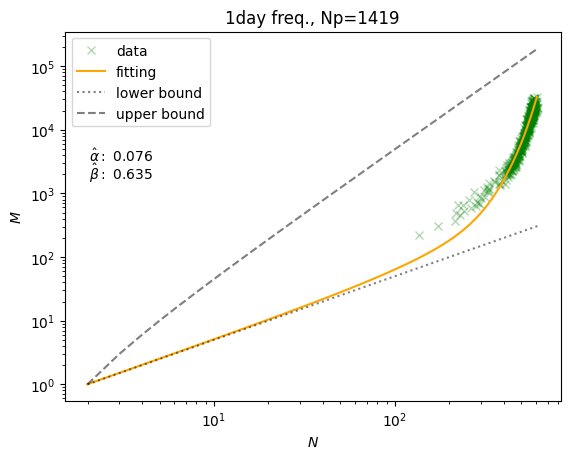

In [17]:
plt.Figure(figsize=(14,7))
Np = 1419
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
alpha = 0.076
beta = 0.635
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting")
plt.text(0.05, 0.65, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.60, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
"""
alpha = 0.1
beta = 0.9
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.5)

alpha = 0.1
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.3)
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("2022/1/1~2023/9/301day freq., Np=1419")
plt.legend()

In [20]:
NN = left["node_norm"]
MM = left["edge_norm"]

# Model3_fixedを用いてパラメータを推定
param, cov = optimize.curve_fit(Model3_fixed, MM, NN, p0=[0.1, 0.5])
print("params: ", param)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_47198/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


params:  [0.05811836 0.82498776]


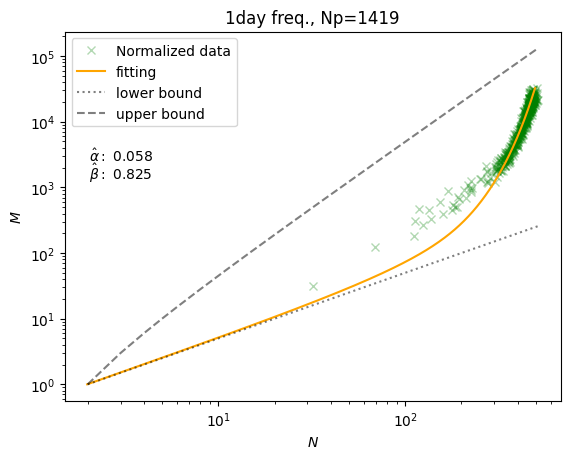

In [22]:
plt.Figure(figsize=(14,7))
Np = 1419
x = np.arange(2,np.max(NN))
y = np.arange(1,np.max(MM))

# data
plt.plot(NN, MM, "x", c="green", alpha=0.3, label = "Normalized data")


# model
alpha = 0.058
beta = 0.825
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting")
plt.text(0.05, 0.65, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
plt.text(0.05, 0.60, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)
"""
alpha = 0.1
beta = 0.9
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.5)

alpha = 0.1
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.3)
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq., Np=1419")
plt.legend()
plt.show()

In [23]:
def calc_N(kappa, Np):
    res = Np * (1 - (2/kappa/Np)*(1 - (1 - kappa/2)**Np) )
    return res

def calc_M(kappa, Np):
    res = kappa*(Np**2 - Np)/8
    return res

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_47198/2063242227.py:14: RuntimeWarning: overflow encountered in scalar power
  N_norm.append( Np * (1 - (2 / (kappa[i]*Np))*(1-(1-(kappa[i]/2))**Np)) )


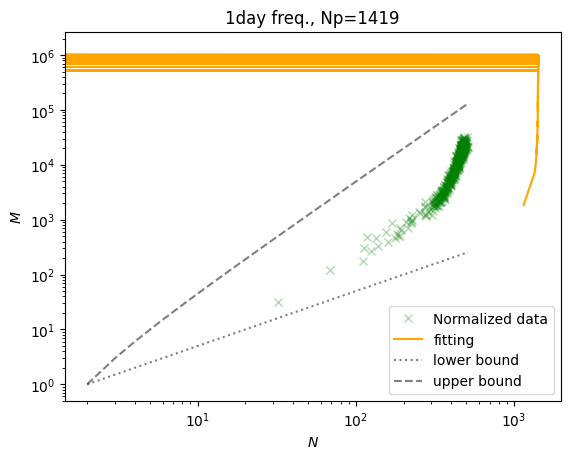

In [32]:
N_norm = []
M_norm = []
Np = 1419

# 正規化したもの
alpha = 0.058
beta = 0.825
kappa = []
for i in range(len(MM)):
    kappa.append( ((alpha+beta)/alpha)**2*2*MM[i]/Np/(Np-1) )


for i in range(len(kappa)):
    N_norm.append( Np * (1 - (2 / (kappa[i]*Np))*(1-(1-(kappa[i]/2))**Np)) )
    M_norm.append( (kappa[i] * Np * (Np - 1)) / 8 )

plt.Figure(figsize=(14,7))
Np = 1419
x = np.arange(2,np.max(NN))
y = np.arange(1,np.max(MM))

# data
plt.plot(NN, MM, "x", c="green", alpha=0.3, label = "Normalized data")

plt.plot(N_norm, M_norm, "-", c="orange", label=f"fitting")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq., Np=1419")
plt.legend()
plt.show()


In [33]:
((alpha+beta)/alpha)**2*2*MM[0]/Np/(Np-1)

0.007372024463264733

In [34]:
(1419**2-1419)*0.0074/8

1861.23135

In [41]:
# 正規化 2
N_norm2 = left["node"] - np.percentile(left["node"], 25)
M_norm2 = left["edge"] - np.percentile(left["edge"], 25)

In [42]:
print(N_norm2)

0     -355.0
1     -318.0
2     -276.0
3     -274.0
4     -269.0
       ...  
602    118.0
603    118.0
604    119.0
605    122.0
606    127.0
Name: node, Length: 607, dtype: float64
